In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
df = pd.read_excel("/content/drive/MyDrive/Hackathon_2021/Predictive Modelling - Data file.xlsx",sheet_name = "train") 
    

In [15]:
df.head()

,id,order_date,order_day_of_week,store,supplier_id,product_id,category,on_order_quantity,on_hand_quantity,product_case_pack,retail_price,replenishment_unit_cost,forecast_start_date,forecast_end_date,Ao_Forecast_Quantity,Minimum_Order_Quantity,Maximum_Order_Quantity,lead_time,suggested_order_quantity,actual_order_quantity
0,1,2017-01-02,Monday,s1,50,28483,c654,0,0.625000,16,2.60,18.56,2017-01-02,2017-01-08,8.50,2,48,2,1,1.0
1,2,2017-01-02,Monday,s1,50,40917,c896,0,0.125000,8,2.95,11.28,2017-01-02,2017-01-08,1.95,2,20,2,1,1.0
2,3,2017-01-02,Monday,s1,50,136366,c896,0,0.833333,6,2.50,4.76,2017-01-02,2017-01-08,0.80,5,40,2,1,2.0
3,4,2017-01-02,Monday,s1,50,136344,c762,0,0.375000,8,3.95,15.04,2017-01-02,2017-01-08,1.55,2,20,2,1,1.0
4,5,2017-01-02,Monday,s1,50,136078,c672,0,0.750000,4,2.80,4.56,2017-01-02,2017-01-08,1.15,2,12,2,1,1.0


### Data Preprocessing

In [16]:
df['order_date_year'] = df['order_date'].dt.year
df['order_date_month'] = df['order_date'].dt.month
df['order_date_day'] = df['order_date'].dt.day
df['order_date_day_of_week'] = df['order_date'].dt.dayofweek

In [17]:
#removing redundant and unnecessary columns
df.drop(columns = ['id','order_day_of_week'],inplace = True)

In [18]:
from datetime import datetime
df.loc[df['order_date'] == df['forecast_start_date']].shape   #indicates order date is same as forecast_start_date for all the records
df['forecast_period'] = (df['forecast_end_date'] - df['forecast_start_date']).dt.days

In [19]:
#dropping date field columns
df.drop(columns = ['order_date','forecast_start_date','forecast_end_date'],inplace = True)

In [20]:
df.head()

,store,supplier_id,product_id,category,on_order_quantity,on_hand_quantity,product_case_pack,retail_price,replenishment_unit_cost,Ao_Forecast_Quantity,Minimum_Order_Quantity,Maximum_Order_Quantity,lead_time,suggested_order_quantity,actual_order_quantity,order_date_year,order_date_month,order_date_day,order_date_day_of_week,forecast_period
0,s1,50,28483,c654,0,0.625000,16,2.60,18.56,8.50,2,48,2,1,1.0,2017,1,2,0,6
1,s1,50,40917,c896,0,0.125000,8,2.95,11.28,1.95,2,20,2,1,1.0,2017,1,2,0,6
2,s1,50,136366,c896,0,0.833333,6,2.50,4.76,0.80,5,40,2,1,2.0,2017,1,2,0,6
3,s1,50,136344,c762,0,0.375000,8,3.95,15.04,1.55,2,20,2,1,1.0,2017,1,2,0,6
4,s1,50,136078,c672,0,0.750000,4,2.80,4.56,1.15,2,12,2,1,1.0,2017,1,2,0,6


In [21]:
cat_cols = ['store','supplier_id','product_id','category',]

In [22]:
df[cat_cols] = df[cat_cols].astype('category')

In [23]:
sample1_df = df.copy()

In [24]:
sample1_df['on_hand_quantity'] = sample1_df['on_hand_quantity'].apply(lambda x: 0 if x < 0 else x)

In [25]:
# Taking 4k records (2000 each from store )for test data 
sample1_s1_test = sample1_df.loc[sample1_df["store"] == 's1'].iloc[-2000:,]
sample1_s2_test = sample1_df.loc[sample1_df["store"] == 's2'].iloc[-2000:,]

In [28]:
sample_test = pd.concat([sample1_s1_test,sample1_s2_test])

In [31]:
sample_train = sample1_df[ ~sample1_df.isin(sample_test)].dropna()

In [32]:
sample_x_train = sample_train.drop(['actual_order_quantity'],axis = 1)
sample_y_train = sample_train['actual_order_quantity']
sample_x_test = sample_test.drop(['actual_order_quantity'],axis = 1)
sample_y_test = sample_test['actual_order_quantity']


In [33]:
print(sample_x_train.shape)
print(sample_y_train.shape)
print(sample_x_test.shape)
print(sample_y_test.shape)


(15668, 19)
(15668,)
(4000, 19)
(4000,)


In [34]:
num_cols = list(set(df.columns.tolist()) - set(cat_cols))
input_num_cols = [x for x in num_cols if x!= "actual_order_quantity"]

In [39]:
# Input feature for model
input_num_cols

['suggested_order_quantity',
 'retail_price',
 'order_date_day',
 'forecast_period',
 'order_date_year',
 'Minimum_Order_Quantity',
 'Ao_Forecast_Quantity',
 'replenishment_unit_cost',
 'on_order_quantity',
 'lead_time',
 'Maximum_Order_Quantity',
 'on_hand_quantity',
 'product_case_pack',
 'order_date_month',
 'order_date_day_of_week']

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
#Standarsing and encoding
scaler2 = StandardScaler()
sample_x_train[input_num_cols]  = scaler2.fit_transform(sample_x_train[input_num_cols])
sample_x_test[input_num_cols]  = scaler2.transform(sample_x_test[input_num_cols])

In [42]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 4.7 MB/s 


In [43]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [46]:
# Getting categorical column to perform encoding
cat_cols_for_encoding = [x for x in cat_cols if x != "store"]

In [47]:
# as there are only two levels in store not using binary encoder
sample_x_train["store"] = sample_x_train["store"].map({'s1':0 ,'s2':1})
sample_x_test["store"] = sample_x_test["store"].map({'s1':0 ,'s2':1})


In [48]:
# perform binary encoding on categorical column and transform it
binaryEncoder = ce.BinaryEncoder(cols= cat_cols_for_encoding,return_df=True)
sample_x_train_cat = binaryEncoder.fit_transform(sample_x_train[cat_cols_for_encoding])

In [50]:
sample_x_train_cat.head()

,supplier_id_0,supplier_id_1,supplier_id_2,product_id_0,product_id_1,product_id_2,product_id_3,product_id_4,product_id_5,product_id_6,product_id_7,product_id_8,product_id_9,category_0,category_1,category_2,category_3,category_4,category_5,category_6
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
4,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [51]:
sample_x_test_cat = binaryEncoder.transform(sample_x_test[cat_cols_for_encoding])

In [52]:
sample_x_test_cat.head()

,supplier_id_0,supplier_id_1,supplier_id_2,product_id_0,product_id_1,product_id_2,product_id_3,product_id_4,product_id_5,product_id_6,product_id_7,product_id_8,product_id_9,category_0,category_1,category_2,category_3,category_4,category_5,category_6
7665,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
7666,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0
7667,1,1,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,1,0,1
7668,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,1,1
7669,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,1


In [53]:
sample_x_train.drop(cat_cols_for_encoding,axis = 1,inplace=True)
sample_x_test.drop(cat_cols_for_encoding,axis = 1,inplace=True)
sample_x_train_final = sample_x_train.join(sample_x_train_cat)
sample_x_test_final = sample_x_test.join(sample_x_test_cat)

In [55]:
sample_x_train_final['store'] = pd.to_numeric( sample_x_train_final['store'])
sample_x_test_final['store'] = pd.to_numeric( sample_x_test_final['store'])

### Training XGBoost model

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:

import xgboost as xgb
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01,.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7,10],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}

In [58]:
# Hyperparameter tuning using GridSearchCV technique
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 10,
                        n_jobs = -1,
                        scoring='neg_root_mean_squared_error')


In [59]:
# fitting model with XGB
%%time
xgb_grid.fit(sample_x_train_final,sample_y_train)

[13:22:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7.99 s, sys: 533 ms, total: 8.52 s
Wall time: 6min 59s


GridSearchCV(cv=10, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7, 10], 'min_child_weight': [4],
                         'n_estimators': [100], 'nthread': [4],
                         'objective': ['reg:linear'], 'subsample': [0.7]},
             scoring='neg_root_mean_squared_error')

In [60]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 100,
 'nthread': 4,
 'objective': 'reg:linear',
 'subsample': 0.7}

In [61]:
# Predicting on train and test data
y_train_xgb_pred = xgb_grid.best_estimator_.predict(sample_x_train_final)
y_test_xgb_pred = xgb_grid.best_estimator_.predict(sample_x_test_final)

### Performance Metrics

In [62]:
#calculating rmse
from sklearn.metrics import mean_squared_error

In [71]:
# RMSE on train sample
mean_squared_error(sample_y_train,y_train_xgb_pred, squared=False)

0.7549871681224014

In [72]:
# RMSE on test sample
mean_squared_error(sample_y_test,y_test_xgb_pred, squared=False)

0.7320606588684848

In [73]:
y_train_xgb_pred.shape

(15668,)

In [74]:
# getting copy of train data for further use
new_df = sample_train.copy()

In [75]:
new_df.head()

,store,supplier_id,product_id,category,on_order_quantity,on_hand_quantity,product_case_pack,retail_price,replenishment_unit_cost,Ao_Forecast_Quantity,Minimum_Order_Quantity,Maximum_Order_Quantity,lead_time,suggested_order_quantity,actual_order_quantity,order_date_year,order_date_month,order_date_day,order_date_day_of_week,forecast_period
0,s1,50,28483,c654,0.0,0.625000,16.0,2.60,18.56,8.50,2.0,48.0,2.0,1.0,1.0,2017.0,1.0,2.0,0.0,6.0
1,s1,50,40917,c896,0.0,0.125000,8.0,2.95,11.28,1.95,2.0,20.0,2.0,1.0,1.0,2017.0,1.0,2.0,0.0,6.0
2,s1,50,136366,c896,0.0,0.833333,6.0,2.50,4.76,0.80,5.0,40.0,2.0,1.0,2.0,2017.0,1.0,2.0,0.0,6.0
3,s1,50,136344,c762,0.0,0.375000,8.0,3.95,15.04,1.55,2.0,20.0,2.0,1.0,1.0,2017.0,1.0,2.0,0.0,6.0
4,s1,50,136078,c672,0.0,0.750000,4.0,2.80,4.56,1.15,2.0,12.0,2.0,1.0,1.0,2017.0,1.0,2.0,0.0,6.0


In [76]:
# appending predicted value to dataset to compare with actual value
new_df['pred_train'] = y_train_xgb_pred

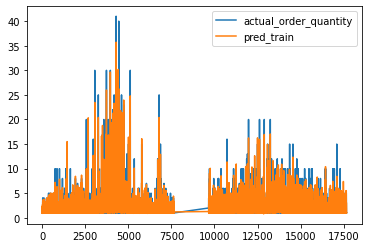

In [77]:
# plotting actual and predicted order quantity for stores
new_df[['actual_order_quantity','pred_train']].plot()

In [78]:
# getting copy of sample test data for further use
new_test_df = sample_test.copy()

In [79]:
# appending predicted result to dataset to compare
new_test_df['pred_test'] = y_test_xgb_pred

In [80]:
new_test_df.head()

,store,supplier_id,product_id,category,on_order_quantity,on_hand_quantity,product_case_pack,retail_price,replenishment_unit_cost,Ao_Forecast_Quantity,...,Maximum_Order_Quantity,lead_time,suggested_order_quantity,actual_order_quantity,order_date_year,order_date_month,order_date_day,order_date_day_of_week,forecast_period,pred_test
7665,s1,90,141367,c1037,0,0.800000,5,16.90,35.70,1.20000,...,6,2,1,1.0,2018,3,6,1,11,1.068365
7666,s1,70,110080,c1101,0,0.388888,18,17.95,144.72,4.60000,...,50,2,1,1.0,2018,3,6,1,28,1.098599
7667,s1,70,140024,c1045,0,1.750000,4,15.90,26.00,4.60000,...,50,2,1,1.0,2018,3,6,1,28,1.490939
7668,s1,50,32945,c793,0,2.166666,6,4.85,9.12,25.45202,...,100,2,4,2.0,2018,3,7,2,7,3.026045
7669,s1,50,109253,c771,0,2.000000,1,1.50,0.56,2.50000,...,40,2,3,3.0,2018,3,7,2,7,2.966349


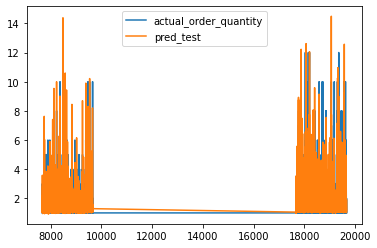

In [81]:
# plotting actual and predicted value on test data
new_test_df[['actual_order_quantity','pred_test']].plot()